# **DSI15 CAPSTONE PROJECT**

An investigation into how far location determines the value of a London property. Please see README for a full description of the problem statement, background and process.

We begin the project by downloading transaction data from the Land Registry for sales during the five years to March 2020.

Basic cleaning and preliminary EDA will follow.


In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')


transactions_19_20 = pd.read_csv('ppd_data_19_20.csv', header = None)
transactions_18_19 = pd.read_csv('ppd_data_18_19.csv', header = None)
transactions_17_18 = pd.read_csv('ppd_data_17_18.csv', header = None)
transactions_16_17 = pd.read_csv('ppd_data_16_17.csv', header = None)
transactions_15_16 = pd.read_csv('ppd_data_15-16.csv', header = None)

all_transactions = pd.concat([transactions_15_16, transactions_16_17, transactions_17_18, transactions_18_19, transactions_19_20])
all_transactions = all_transactions.drop_duplicates()

In [107]:
# rename the columns based on information from Land Registry

naming_dict = {0: 'reference' ,
              1: 'price',
              2: 'date',
              3: 'postcode',
              4: 'property_type',
              5: 'new_build',
              6: 'estate_type',
              7: 'primary_address',
              8: 'secondary_address',
              9: 'street',
              10: 'locality',
              11: 'city',
              12: 'district',
              13: 'county',
              14: 'transaction_type',
              15: 'url'}

all_transactions = all_transactions.rename(columns = naming_dict)

In [109]:
all_transactions.head(1)

,reference,price,date,postcode,property_type,new_build,estate_type,primary_address,secondary_address,street,locality,city,district,county,transaction_type,url
0,25EA59F9-A161-4D50-E050-A8C0630562D0,455000,2015-10-23,E1 0AE,F,N,L,NaN,338,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...


In [25]:
# confirm the number of unique postcodes within the dataset

all_transactions['postcode'].nunique()

67341

In [118]:
# copy the dataset, and select only the columns we will need

cleaned_transactions = all_transactions.copy()
cleaned_transactions = cleaned_transactions[['reference','price', 'date', 'postcode', 'property_type', 'new_build', 'estate_type', 'primary_address','secondary_address','district', 'transaction_type']]
cleaned_transactions.shape

(351443, 11)

In [64]:
# check for missing values

cleaned_transactions.isna().sum()

reference                 0
price                     0
date                      0
postcode               2315
property_type             0
new_build                 0
estate_type               0
primary_address      172836
secondary_address         0
district                  0
transaction_type          0
dtype: int64

In [119]:
# checking tranasactions are all relevant

cleaned_transactions['property_type'].value_counts()

F    228703
T     73264
O     24197
S     19782
D      5497
Name: property_type, dtype: int64

**PROPERTY TYPES**	

D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other

According to the Land Registry:

- We only record the above categories to describe property type, we do not separately identify bungalows.
- End-of-terrace properties are included in the Terraced category above.
- ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values.

Property type 'Other' includes mixed use properties, and properties being sold for redevelopment (including a pub, an Esso garage etc). These should be dropped, we are focused on residential properties that are being sold as such.

In [120]:
other = cleaned_transactions['property_type'] == 'O'
cleaned_transactions = cleaned_transactions.loc[~other]
cleaned_transactions.shape

(327246, 11)

In [121]:
#checking for outliers on price

cleaned_transactions['price'].agg(['max', 'min'])

max    160000000
min          400
Name: price, dtype: int64

**DEALING WITH PRICE OUTLIERS**

While the upper price limit of £160m looks realistic (part of the development at One Hyde Park), the lower limit of £400 doesn't. There are a couple of hundred properties at the low end of the price scale where the prices are simply unrealistic.

Amongst these are freehold terraced or semi detached properties in desirable locations - these all fall within 'transaction_type B'. When we investigate what this means, we find out that:

'PPD Category Type - Indicates the type of Price Paid transaction.
A = Standard Price Paid entry, includes single residential property sold for value.
B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals.'

The vast majority of the very cheap properties are type 'B', and it's likely that we are looking mostly at shared ownerships. Also there are properties that are likely to be on very short leases. It is around the 60k mark that we start to see significant numbers of properties that might be selling for a fair market rate (ie transaction type A, freehold flats in non central areas).

It's likely that there will be a few unrealisticly priced properties above this mark, but short of reseaching the history of every one of them with estate agents, we need to cutoff at some lower price level.


In [144]:
cleaned_transactions = cleaned_transactions[cleaned_transactions['price'] > 60000]
cleaned_transactions.shape

(326909, 11)

In [147]:
# check for duplicates without unique reference, but including door numbers

(cleaned_transactions.duplicated(subset = ['price', 'date', 'postcode', 'property_type', 'new_build', 'estate_type', 'primary_address', 'secondary_address','district', 'transaction_type'])).sum()

264

In [150]:
# drop the duplicates

cleaned_transactions = cleaned_transactions.drop_duplicates(subset = ['price', 'date', 'postcode', 'property_type', 'new_build', 'estate_type', 'primary_address','secondary_address','district', 'transaction_type'])
cleaned_transactions.shape

(326645, 11)

In [151]:
# now we've checked for duplication, we can drop some of the columns

cleaned_transactions = cleaned_transactions.drop(columns = ['primary_address', 'secondary_address'])
cleaned_transactions.shape

(326645, 8)

In [152]:
# check again for missing values

cleaned_transactions.isna().sum()

price                 0
date                  0
postcode            815
property_type         0
new_build             0
estate_type           0
district              0
transaction_type      0
dtype: int64

In [153]:
#transactions that have missing postcodes can be dropped

cleaned_transactions = cleaned_transactions.dropna()
cleaned_transactions.shape

(325830, 8)

In [70]:
#convert date column to datetime

cleaned_transactions['date'] = pd.to_datetime(cleaned_transactions['date'])
cleaned_transactions.dtypes

price                        int64
date                datetime64[ns]
postcode                    object
property_type               object
new_build                   object
estate_type                 object
district                    object
transaction_type            object
dtype: object

In [156]:
# check that no postcodes have appeared an implausible number of times

cleaned_transactions['postcode'].value_counts()

SW11 7AY    246
E20 1GQ     246
E15 1DA     208
WC2R 1AB    194
SW1W 0AJ    177
           ... 
N9 9RW        1
W11 3AD       1
SW7 4QP       1
SE21 8NY      1
N16 7QA       1
Name: postcode, Length: 62138, dtype: int64

In [157]:
#new build flats account for the postcodes that come up multiple times

cleaned_transactions[cleaned_transactions['postcode'] == 'SW11 7AY'].head()

,price,date,postcode,property_type,new_build,estate_type,district,transaction_type
267665,837125,2018-11-21,SW11 7AY,F,Y,L,WANDSWORTH,B
267666,1420000,2018-11-21,SW11 7AY,F,Y,L,WANDSWORTH,A
267667,710500,2018-11-27,SW11 7AY,F,Y,L,WANDSWORTH,A
267668,1211450,2019-01-31,SW11 7AY,F,Y,L,WANDSWORTH,A
267669,1050000,2018-11-30,SW11 7AY,F,N,L,WANDSWORTH,B


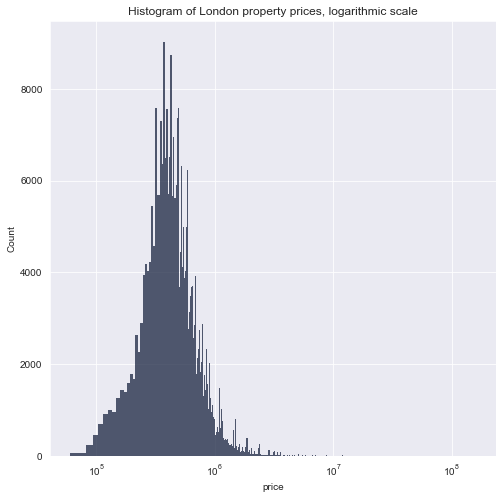

In [42]:
# take a first look at the target variable
# histogram of price data shows long tail to the right, plot again on logarithmic scale

fig, ax = plt.subplots(figsize = (8,8))
sns.histplot(cleaned_transactions['price'], palette = 'Blues')
plt.xscale('log')
plt.title('Histogram of London property prices, logarithmic scale');

In [76]:
# unless we want to build a time series model, we need to use data from a period where the prices are relatively stable
# we need to check that this is the case before we go much further

cleaned_transactions['year'] = cleaned_transactions['date'].dt.year
cleaned_transactions.head(2)

,price,date,postcode,property_type,new_build,estate_type,district,transaction_type,year
0,455000,2015-10-23,E1 0AE,F,N,L,TOWER HAMLETS,A,2015
1,378000,2015-08-25,E1 0AE,F,N,L,TOWER HAMLETS,A,2015


''

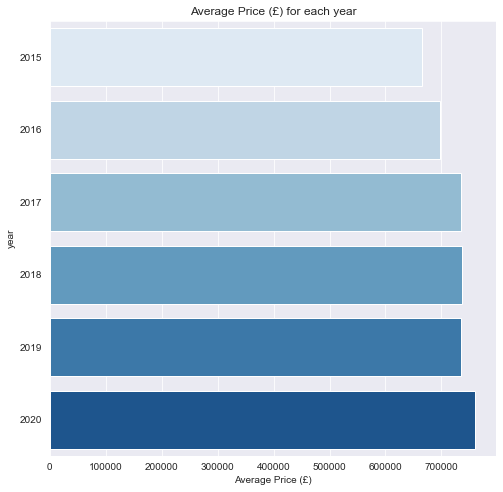

In [79]:
# visualise how average prices depend on the year

fig, ax = plt.subplots(figsize = (8,8))
year_groups = pd.DataFrame(cleaned_transactions.groupby('year')['price'].mean()).reset_index().sort_values(by = 'price')
sns.barplot(x = 'price', y = 'year', data = year_groups, palette = 'Blues', orient = 'h')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Average Price (£)')
plt.title('Average Price (£) for each year')
;

The prices are largely stable over the period in question. Later we might consider dropping the data from 2015 and possibly 2016 to see if this helps, but in the meantime we should be able to work with the whole dataset.